# **Volatility Skew Trading**

Volatility skew is a well-known phenomenon in the options market that refers to the difference in implied volatility (IV) between out-of-the-money (OTM) calls and puts. This skew arises from market sentiment, supply and demand imbalances, and behavioral factors — most notably loss aversion.

## Why Trade the Skew?

Options were originally introduced as hedging instruments, and many investors are willing to overpay for downside protection. This behavioral bias is well described by **Prospect Theory** (Kahneman & Tversky, 1979), which suggests that individuals tend to overweight small-probability events and exhibit strong aversion to losses.

As options traders, we can exploit these persistent mispricings by constructing volatility skew trading strategies, aiming to profit when market-implied fears (e.g., demand for puts) fail to materialize. These strategies typically assume that the pricing dislocation is temporary or exaggerated relative to actual realized outcomes.

The notebook is structured as follows:
1. [Read SPX Options Data](#read)
2. [Plot the Volatility Skew](#plot)
3. [Compute the Skew](#skew)
3. [Conclusion](#conclusion)

# Import Libraries

In [102]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from utility import remove_illiquid_options, reshape_options_long_to_wide, reshape_options_wide_to_long
from config.constants import OPTION_TYPES

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
file = "data/intermediate/full_spx_options_2023.parquet"

cols = [
    "strike", "underlying_last", 
    "dte", "expiry",
    "c_delta", "p_delta", 
    "c_iv", "p_iv",
    "c_last", "p_last",
    "c_volume", "p_volume",
    "c_bid", "c_ask",
    "p_bid", "p_ask"
]

options = pd.read_parquet(file, columns=cols)
options

,strike,underlying_last,dte,expiry,c_delta,p_delta,c_iv,p_iv,c_last,p_last,c_volume,p_volume,c_bid,c_ask,p_bid,p_ask
date,,,,,,,,,,,,,,,,
2023-01-04,1000.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,8.17536,3041.37,0.03,1.0,7.0,2846.8,2848.3,0.0,0.05
2023-01-04,1200.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,7.06724,0.00,0.00,1.0,0.0,2646.8,2648.3,0.0,0.05
2023-01-04,1400.0,3853.39,0.0,2023-01-04,1.00000,-0.00025,NaN,6.13893,0.00,0.00,0.0,0.0,2427.6,2471.0,0.0,0.05
2023-01-04,1600.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,5.33125,2417.29,0.00,1.0,0.0,2246.8,2248.3,0.0,0.05
2023-01-04,1800.0,3853.39,0.0,2023-01-04,1.00000,0.00000,NaN,4.61644,0.00,0.00,0.0,0.0,2046.8,2048.3,0.0,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,7200.0,4772.17,2184.0,2029-12-21,0.29633,-1.00000,0.17401,NaN,0.00,0.00,0.0,0.0,286.8,366.8,1550.9,1630.90
2023-12-29,7400.0,4772.17,2184.0,2029-12-21,0.27129,-1.00000,0.17063,NaN,0.00,0.00,0.0,0.0,245.4,325.4,1669.0,1749.00
2023-12-29,7600.0,4772.17,2184.0,2029-12-21,0.24709,-1.00000,0.16688,NaN,0.00,0.00,0.0,0.0,208.7,288.7,1791.8,1871.80


# Remove illiquid options

In order to obtain more reliable backtest results, we are going to remove illiquid options as trading them would lead to high slippage, bid-ask spread which can maek our edge vanish. 

In [104]:
options = reshape_options_wide_to_long(options)
options.head()

,strike,underlying_last,dte,expiry,delta,iv,last,volume,bid,ask,option_type
date,,,,,,,,,,,
2023-01-04,100.0,3853.39,345.0,2023-12-15,1.0000,NaN,3698.92,2.0,3690.0,3703.4,C
2023-01-04,100.0,3853.39,345.0,2023-12-15,-0.0005,1.11594,0.07,1.0,0.0,0.1,P
2023-01-04,200.0,3853.39,16.0,2023-01-20,1.0000,NaN,3618.19,1.0,3647.0,3650.0,C
2023-01-04,200.0,3853.39,44.0,2023-02-17,1.0000,NaN,3647.38,1.0,3631.2,3643.6,C
2023-01-04,200.0,3853.39,72.0,2023-03-17,1.0000,NaN,3587.35,1.0,3628.7,3638.0,C


## Volume Filter

Since Open Interest is not available in our dataset, we use daily traded **volume** as a proxy for option contract liquidity. While not a perfect substitute, volume provides a reasonable indication of market activity and tradability. 

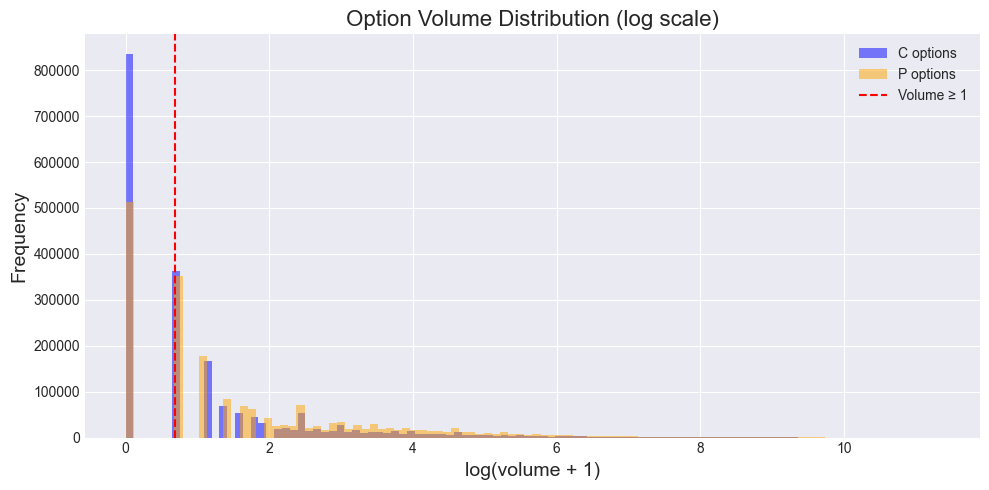

In [105]:
# Add 1 to avoid log(0), then take log
log_volumes = (options["volume"] + 1).apply(np.log)

plt.figure(figsize=(10, 5))

for opt_type, color in zip(OPTION_TYPES, ["blue", "orange"]):
    subset = options[options["option_type"] == opt_type]
    log_volumes = (subset["volume"] + 1).apply(np.log)
    log_volumes.hist(bins=100, alpha=0.5, label=f"{opt_type} options", color=color)

plt.axvline(np.log(2), color='r', linestyle='--', label='Volume ≥ 1')
plt.title("Option Volume Distribution (log scale)", fontsize=16)
plt.xlabel("log(volume + 1)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We remove options with very low volume (e.g., volume < 1), as these are likely illiquid and may not reflect reliable pricing or realistic execution.

In [106]:
volume_threshold = 1

## Bid-Ask Spread Filter

The bid-ask spread is a key measure of transaction cost and liquidity. Options with wide spreads are harder to trade efficiently and may reflect stale or unreliable pricing.

First we drop 0 ask and bid values, as they indicate that no trading occured at a particular date for a specific option.


Now we filter out options where the **relative bid-ask spread** exceeds a threshold (e.g., 25%), defined as:

$$
\text{Relative Spread} = \frac{\text{Ask} - \text{Bid}}{0.5 \times (\text{Ask} + \text{Bid})}
$$

In [107]:
options["mid"] = 0.5 * (options["bid"] + options["ask"])
options["rel_spread"] = (options["ask"] - options["bid"]) / options["mid"]

options[["bid", "ask", "mid", "rel_spread"]]

,bid,ask,mid,rel_spread
date,,,,
2023-01-04,3690.0,3703.4,3696.70,0.003625
2023-01-04,0.0,0.1,0.05,2.000000
2023-01-04,3647.0,3650.0,3648.50,0.000822
2023-01-04,3631.2,3643.6,3637.40,0.003409
2023-01-04,3628.7,3638.0,3633.35,0.002560
...,...,...,...,...
2023-12-29,3.5,13.0,8.25,1.151515
2023-12-29,6348.4,6435.3,6391.85,0.013595
2023-12-29,6033.5,6087.7,6060.60,0.008943


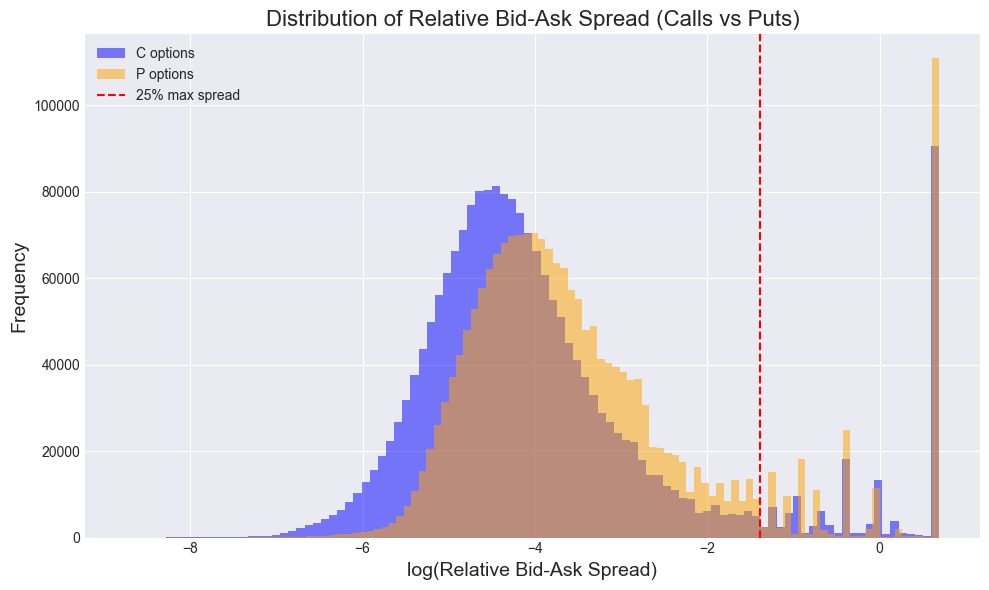

In [108]:
plt.figure(figsize=(10, 6))

for opt_type, color in zip(OPTION_TYPES, ["blue", "orange"]):
    subset = options[options["option_type"] == opt_type]
    log_rel_spread = (subset["rel_spread"] + 1e-6).apply(np.log)
    log_rel_spread.hist(bins=100, alpha=0.5, label=f"{opt_type} options", color=color)

plt.axvline(np.log(0.25), color='red', linestyle='--', label="25% max spread")
plt.xlabel("log(Relative Bid-Ask Spread)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Relative Bid-Ask Spread (Calls vs Puts)", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A threshold of 25% seems a reasonble choice for removing too large bid-ask spreads.

In [109]:
spread_threshold = 0.25

## Moneyness filter

We filter options based on their moneyness (strike / underlying price) to focus on contracts with meaningful market activity. Deep ITM or far OTM options are often illiquid or mispriced, so we retain only those within a reasonable band (e.g., 0.8 to 1.2).

In [110]:
options["moneyness"] = options["strike"] / options["underlying_last"]

options["moneyness_bin"] = pd.cut(
    options["moneyness"],
    bins=np.arange(0.5, 1.6, 0.05),
    include_lowest=True
)

avg_vol = (
    options.groupby(["option_type", "moneyness_bin"])["volume"]
    .mean()
    .reset_index()
)

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_8981/1300706182.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  options.groupby(["option_type", "moneyness_bin"])["volume"]


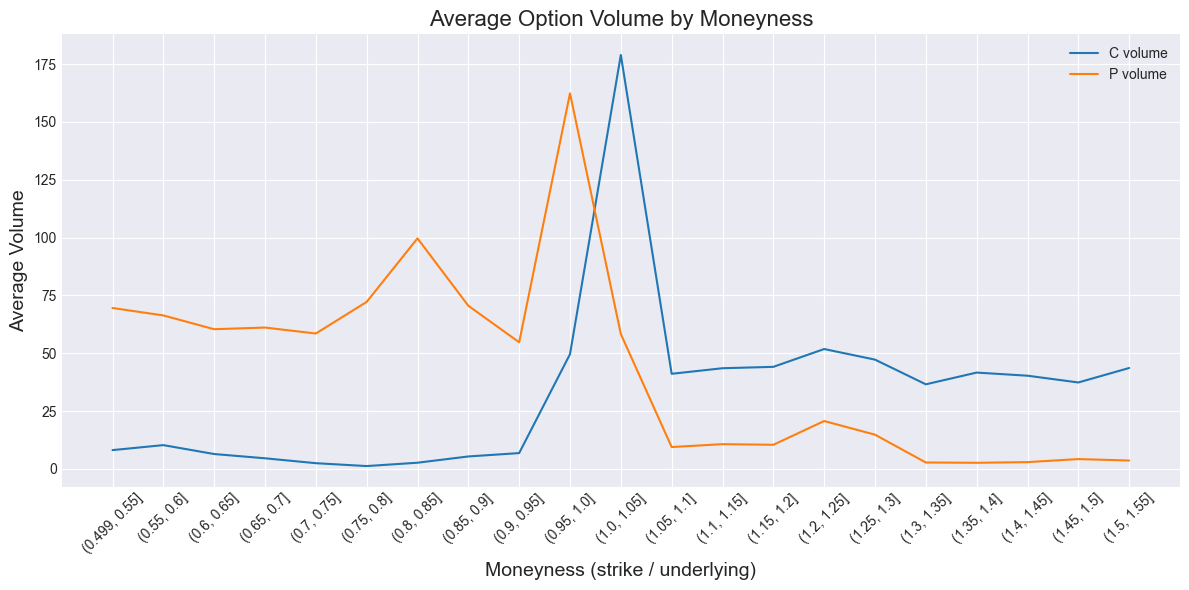

In [111]:
plt.figure(figsize=(12, 6))

for option_type in OPTION_TYPES:
    subset = avg_vol[avg_vol["option_type"] == option_type]
    plt.plot(
        subset["moneyness_bin"].astype(str),
        subset["volume"],
        label=f"{option_type} volume"
    )

plt.xticks(rotation=45)
plt.xlabel("Moneyness (strike / underlying)", fontsize=14)
plt.ylabel("Average Volume", fontsize=14)
plt.title("Average Option Volume by Moneyness", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We observe that average volume for OTM Calls drops sharply beyond a moneyness of 1.2, indicating low liquidity. For OTM Puts, volume remains relatively high down to a moneyness of 0.8, but falls off below that. Therefore, we retain options within the band [0.8, 1.2] to focus on the most liquid and tradeable strikes.

In [112]:
moneynes_lower_band = 0.8
moneynes_upper_band = 1.2

## Apply the filters

In [113]:
n = len(options)

# Volume filter
options = options[options["volume"] >= volume_threshold].copy()

# Bid-Ask filter
options = options[(options["bid"] > 0) & (options["ask"] > 0)].copy()
options = options[options["rel_spread"] <= spread_threshold].copy()

# Moneyness filter
options = options[(options["moneyness"] >= moneynes_lower_band) & (options["moneyness"] <= moneynes_upper_band)]

pct_dropped = 100 * (1 - len(options) / n)
print(f"Percentage of observations dropped across all filters: {pct_dropped:.2f}%")

Percentage of observations dropped across all filters: 50.65%


# Build the Synthetic 30-DTE Skew

To measure skew consistently, we compare the implied volatilities of an OTM put and call at a fixed 30-day time-to-expiry. Since shorter-dated options tend to show steeper skews and longer-dated ones flatter, holding expiry constant allows for meaningful comparisons over time.

We construct a synthetic 30-DTE skew by interpolating between the two closest expiries bracketing 30 days. While not directly tradable, this synthetic skew mirrors what institutional desks track and isolates true shifts in sentiment from calendar-driven effects.

## Compute Interpolated 30-DTE IVs

To construct the 30-day implied volatilities, we interpolate between the two expiries that bracket 30 DTE — one below $T_1$ and one above $T_2$. For choosing the strike, we are going to use a method called **delta targeting**, which consists in choosing the strikes such that the delta is ±0.25.

In addition, instead of interpolating the full volatility smile, we focus only on the options of interest:

- A 25-delta **put** and **call**, denoted: $IV^{Put}_{30DTE}$, $IV^{Call}_{30DTE}$
  
- An **ATM IV**, estimated as the average of call and put IVs with delta ≈ 0


The interpolation is performed in total variance space using:

$$
V_* = V_1 + \frac{T_* - T_1}{T_2 - T_1} \cdot (V_2 - V_1)
\qquad
IV_* = \sqrt{\frac{V_*}{T_*}}
$$

Where:

$$
V_i = IV_i^2 \cdot \frac{DTE_i}{252}
$$

This gives us smooth and consistent synthetic 30-DTE IVs for measuring skew over time.

In [ ]:
def interp_iv(df_lower, df_upper, T1, T2, target_dte, target_delta):
    """
    Interpolate IV at a given delta and target DTE using two expiry slices.
    """
    row1 = df_lower.iloc[(df_lower['delta'] - target_delta).abs().argmin()]
    
    if T2 == T1:
        return row1.iv  # no interpolation needed

    row2 = df_upper.iloc[(df_upper['delta'] - target_delta).abs().argmin()]
    
    t1, t2 = T1 / 252, T2 / 252
    V1 = row1.iv**2 * t1
    V2 = row2.iv**2 * t2

    t_target = target_dte / 252
    V_target = V1 + (t_target - t1) / (t2 - t1) * (V2 - V1)

    if V_target <= 0 or t_target <= 0:
        return np.nan
    
    return np.sqrt(V_target / t_target)

## Compute the 25-Delta Skew

To systematically measure asymmetry in implied volatility across strikes, we compute the **25-delta skew** — a standard metric in volatility trading.

Instead of relying on fixed moneyness levels (e.g., 90% / 110%), we use **delta targeting**, selecting the OTM put and call with deltas near -0.25 and +0.25. This approach is more robust, as delta accounts for the strike, expiry, volatility, and underlying price — resulting in a consistent and normalized strike selection.

The absolute 25-delta skew is given by:

$$
25\Delta\ \text{Skew} = IV_{25\Delta\,Put} - IV_{25\Delta\,Call}
$$

Lastly, we normalize the absolute skew by the ATM IV to obtain a scale-invariant measure, allowing for fair comparisons across time, assets, and expiries — even in different volatility regimes.
$$
\text{Normalized Skew} = \frac{IV_{25\Delta\,Put} - IV_{25\Delta\,Call}}{IV_{ATM}}
$$

In [115]:
def compute_skew(iv_put, iv_call, iv_atm):
    skew_abs = iv_put - iv_call
    skew_norm = skew_abs / iv_atm if iv_atm and not np.isnan(iv_atm) else np.nan
    return skew_abs, skew_norm

## 🧮 Compute the Synthetic 30-DTE 25-Delta Skew

Now we bring everything together by applying the previous steps for each trading day to compute the synthetic skew.

For each date *t*, we proceed as follows:

**Step 1:** Extract the two expiries closest to the 30-day target — one below and one above.

**Step 2:** For each expiry, filter the options to find the contracts with deltas closest to ±0.25 — representing the 25-delta OTM **put** and **call**.

**Step 3:** Interpolate the implied volatilities of these 25-delta options in total variance space to obtain a synthetic 30-DTE IV for both put and call.

**Step 4:** Repeat the interpolation for **ATM options**, using a target delta of 0 for both puts and calls.

**Step 5:** Compute the **ATM IV** as the average of the interpolated ATM call and put IVs.

**Step 6:** Compute the skew:
- **Absolute skew**: $\text{Skew}_{\text{abs}} = IV_{\text{put}} - IV_{\text{call}}$
- **Normalized skew**: $\text{Skew}_{\text{norm}} = \frac{IV_{\text{put}} - IV_{\text{call}}}{IV_{\text{ATM}}}$

In [116]:
def compute_synthetic_skew(options, target_dte=30, target_delta_otm=0.25, target_delta_atm=0.5):
    results = []

    for date, df in options.groupby("date"):
        exps = df['dte'].dropna().unique()
        below = exps[exps <= target_dte]
        above = exps[exps >= target_dte]
        if not len(below) or not len(above):
            continue

        T1, T2 = below.max(), above.min()
        df1, df2 = df[df['dte'] == T1], df[df['dte'] == T2]
        
        iv_put  = interp_iv(df1[df1.option_type == 'P'], df2[df2.option_type == 'P'], T1, T2, target_dte, -target_delta_otm)
        iv_call = interp_iv(df1[df1.option_type == 'C'], df2[df2.option_type == 'C'], T1, T2, target_dte, target_delta_otm)

        iv_atm_put  = interp_iv(df1[df1.option_type == 'P'], df2[df2.option_type == 'P'], T1, T2, target_dte, -target_delta_atm)
        iv_atm_call = interp_iv(df1[df1.option_type == 'C'], df2[df2.option_type == 'C'], T1, T2, target_dte, target_delta_atm)
        iv_atm = np.nanmean([iv_atm_call, iv_atm_put])

        skew_abs, skew_norm = compute_skew(iv_put, iv_call, iv_atm)

        results.append({
            'date':       date,
            'iv_put_30':  iv_put,
            'iv_call_30': iv_call,
            'iv_atm_30':  iv_atm,
            'skew_abs':   skew_abs,
            'skew_norm':  skew_norm
        })

    return pd.DataFrame(results).set_index('date').sort_index()

In [117]:
skew_df = compute_synthetic_skew(options, target_dte=30)
skew_df

,iv_put_30,iv_call_30,iv_atm_30,skew_abs,skew_norm
date,,,,,
2023-01-04,0.230950,0.186920,0.209115,0.044030,0.210554
2023-01-05,0.233239,0.189412,0.211655,0.043827,0.207068
2023-01-06,0.211219,0.179939,0.195825,0.031281,0.159737
2023-01-09,0.218010,0.188590,0.200680,0.029420,0.146602
2023-01-10,0.211920,0.180930,0.193040,0.030990,0.160537
...,...,...,...,...,...
2023-12-22,0.118545,0.103150,0.106070,0.015396,0.145145
2023-12-26,0.119700,0.100920,0.106075,0.018780,0.177045
2023-12-27,0.114400,0.097640,0.101930,0.016760,0.164427


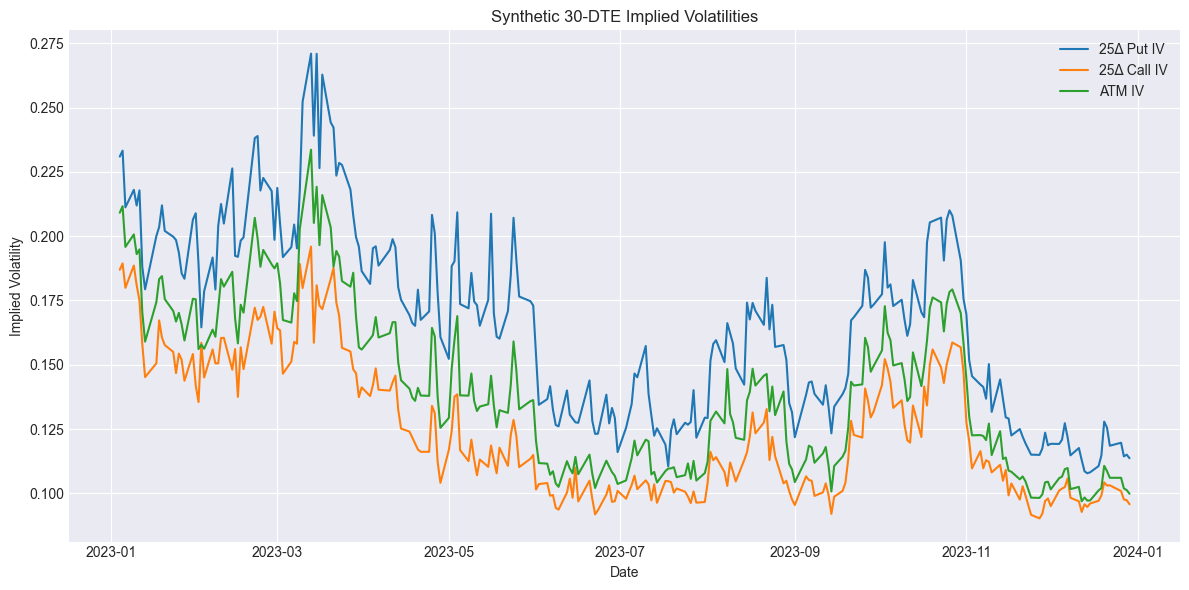

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(skew_df.index, skew_df['iv_put_30'], label='25Δ Put IV')
plt.plot(skew_df.index, skew_df['iv_call_30'], label='25Δ Call IV')
plt.plot(skew_df.index, skew_df['iv_atm_30'], label='ATM IV')

plt.title('Synthetic 30-DTE Implied Volatilities')
plt.xlabel('Date')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The relative order here is what woudl expect from a smirk skew shape where the IV for OTM Put is larger than than the ATM IV itself larger than OTM Call IV. We can see of course the are moving in the same direction whihc is expected and also that the OTM Put Iv is much more volatile  whihc is also expected.

In [119]:
skew_df[["iv_put_30", "iv_atm_30", "iv_call_30"]].corr()

,iv_put_30,iv_atm_30,iv_call_30
iv_put_30,1.000000,0.976074,0.921216
iv_atm_30,0.976074,1.000000,0.973665
iv_call_30,0.921216,0.973665,1.000000


In [120]:
skew_df[["iv_put_30", "iv_atm_30", "iv_call_30"]].std()

iv_put_30     0.036744
iv_atm_30     0.031646
iv_call_30    0.026354
dtype: float64

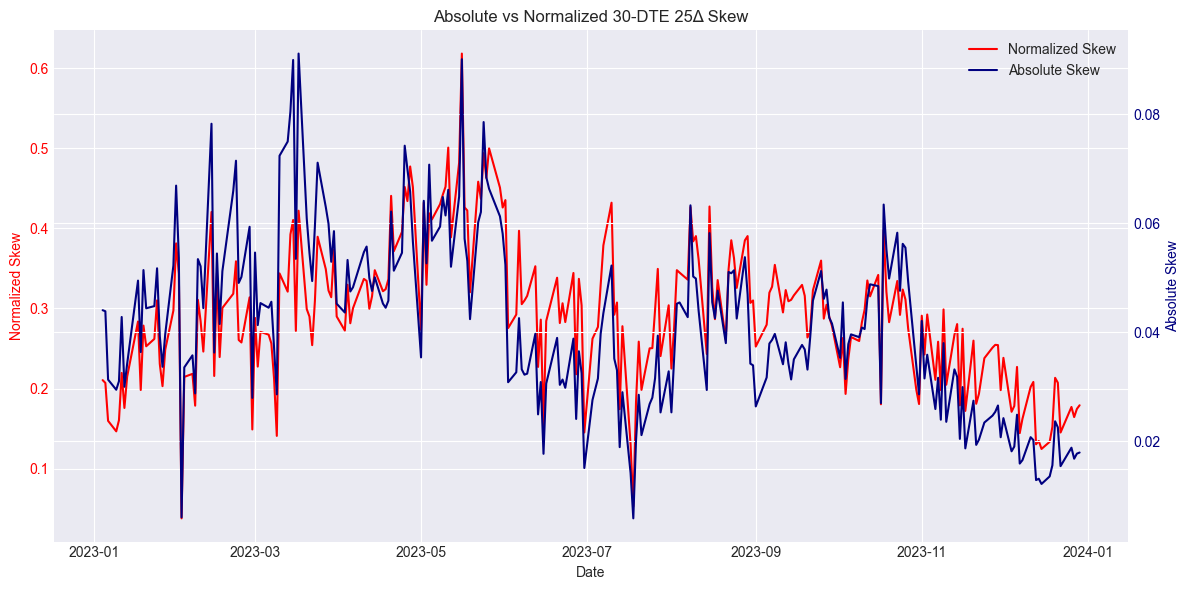

In [121]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(skew_df['skew_norm'], color="red", label="Normalized Skew")
ax1.set_ylabel("Normalized Skew", color="red")
ax1.tick_params(axis='y', labelcolor="red")

ax2 = ax1.twinx()
ax2.plot(skew_df['skew_abs'], color="navy", label="Absolute Skew")
ax2.set_ylabel("Absolute Skew", color="navy")
ax2.tick_params(axis='y', labelcolor="navy")

ax1.set_title("Absolute vs Normalized 30-DTE 25Δ Skew")
ax1.set_xlabel("Date")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()

As you cna see the absolite skew is more noisy over time as volatiliy regimes changes, especially in the hogh volaitltiy regimes for the first 3 months the basolite skew has been much more respovive comapred to the normalized onen whihc is more stable and thus would provide more accurate signals.

As we cann see the IVs move in tandem, however we notic ethe OTM Put IV is much more volatile

In [122]:
skew_df[["skew_norm", "skew_abs"]].std()

skew_norm    0.088714
skew_abs     0.016141
dtype: float64

In [123]:
skew_df.std()

iv_put_30     0.036744
iv_call_30    0.026354
iv_atm_30     0.031646
skew_abs      0.016141
skew_norm     0.088714
dtype: float64

## Construct the strategy

In [124]:
spy = yf.download("SPY", start=options.index[0], end=options.index[-1])
spy

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_8981/4238085849.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start=options.index[0], end=options.index[-1])
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2023-01-04,371.011017,373.060583,367.375919,370.450269,85934100
2023-01-05,366.776550,369.154818,366.177152,369.038809,76970500
2023-01-06,375.187439,376.318583,366.805485,369.899159,104189600
2023-01-09,374.974762,380.620775,374.791101,377.401386,73978100
2023-01-10,377.604431,377.672113,373.437617,374.385071,65358100
...,...,...,...,...,...
2023-12-21,463.942047,464.216858,460.153548,462.597405,86667500
2023-12-22,464.874420,466.572378,462.960567,465.080521,67126600


In [125]:
options = pd.merge(options, spy["Close"], left_index=True, right_index=True)
options

,strike,underlying_last,dte,expiry,delta,iv,last,volume,bid,ask,option_type,mid,rel_spread,moneyness,moneyness_bin,SPY
2023-01-04,3090.0,3853.39,16.0,2023-01-20,0.99950,0.00027,952.44,1.0,762.10,767.20,C,764.65,0.006670,0.801891,"(0.8, 0.85]",371.011017
2023-01-04,3090.0,3853.39,86.0,2023-03-31,0.96797,0.25597,932.74,1.0,787.30,794.60,C,790.95,0.009229,0.801891,"(0.8, 0.85]",371.011017
2023-01-04,3090.0,3853.39,27.0,2023-01-31,-0.00760,0.33857,1.50,2.0,0.85,0.95,P,0.90,0.111111,0.801891,"(0.8, 0.85]",371.011017
2023-01-04,3090.0,3853.39,44.0,2023-02-17,-0.01812,0.31434,2.90,21.0,2.75,2.95,P,2.85,0.070175,0.801891,"(0.8, 0.85]",371.011017
2023-01-04,3090.0,3853.39,55.0,2023-02-28,-0.02421,0.30173,0.00,1.0,4.20,4.50,P,4.35,0.068966,0.801891,"(0.8, 0.85]",371.011017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,5700.0,4783.83,78.0,2024-03-15,-1.00000,NaN,863.99,1.0,852.10,864.20,P,858.15,0.014100,1.191514,"(1.15, 1.2]",467.858093
2023-12-28,5700.0,4783.83,176.0,2024-06-21,-1.00000,NaN,1050.50,2.0,792.20,805.90,P,799.05,0.017145,1.191514,"(1.15, 1.2]",467.858093
2023-12-28,5700.0,4783.83,358.0,2024-12-20,-1.00000,NaN,754.68,1.0,724.60,735.40,P,730.00,0.014795,1.191514,"(1.15, 1.2]",467.858093
2023-12-28,5700.0,4783.83,386.0,2025-01-17,-1.00000,NaN,0.00,5.0,721.30,727.90,P,724.60,0.009108,1.191514,"(1.15, 1.2]",467.858093


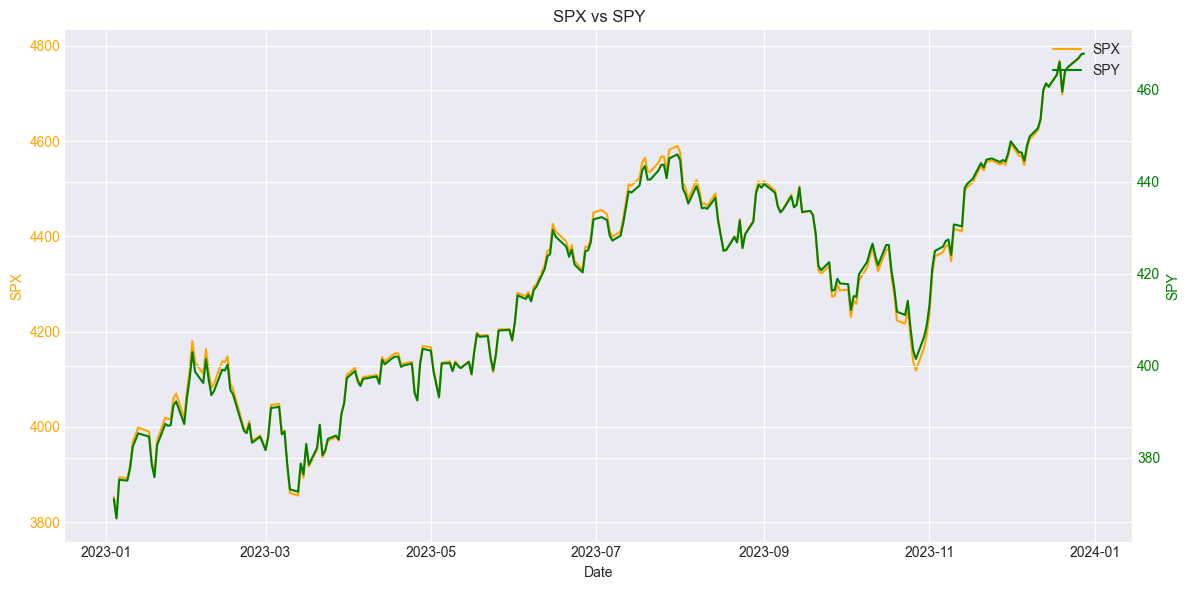

In [126]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(options["underlying_last"], color="orange", label="SPX")
ax1.set_ylabel("SPX", color="orange")
ax1.tick_params(axis='y', labelcolor="orange")

ax2 = ax1.twinx()
ax2.plot(options["SPY"], color="green", label="SPY")
ax2.set_ylabel("SPY", color="green")
ax2.tick_params(axis='y', labelcolor="green")

ax1.set_title("SPX vs SPY")
ax1.set_xlabel("Date")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()

In [127]:
spx_spy_corr = options[["underlying_last", "SPY"]].corr().iloc[0, 1]
print("Correlation between SPX Index and SPY ETF:", spx_spy_corr)

#data.drop("SPX", axis=1, inplace=True)

Correlation between SPX Index and SPY ETF: 0.9991345438568632


Here we can use the SPY ETF as a proxy for the SPX inde which is not tradeable.